Enter the path to the CSV file: /content/Wifi_mapper_dataset.csv


**F1 Score (Random Forest - Dead Zone Detection):** 1.0000

**RMSE (Gaussian Process - Distance Estimation):** 1.0366e-03

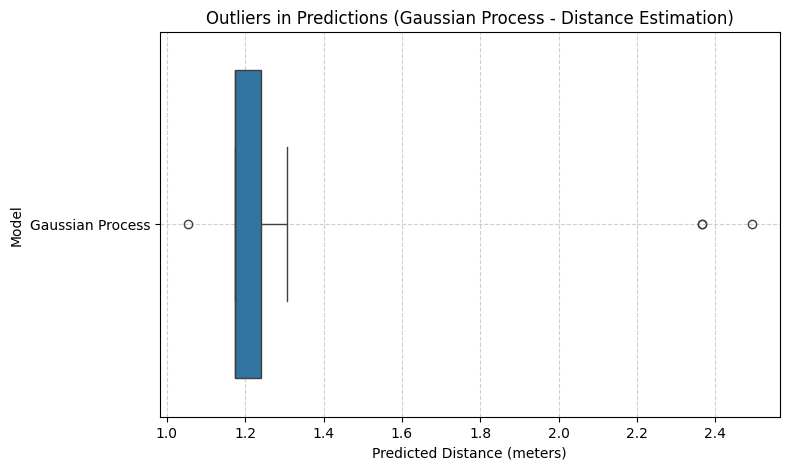

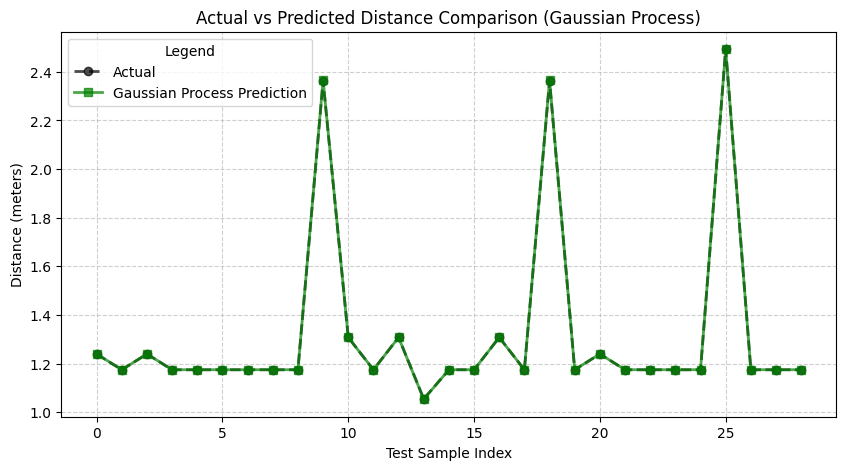

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import os

# Function to check if the file is a CSV
def validate_csv(file_path):
    if not file_path.lower().endswith('.csv'):
        raise ValueError("Invalid file format. Please provide a CSV file.")
    return file_path

# User input for file path
csv_file = input("Enter the path to the CSV file: ")
validate_csv(csv_file)
data = pd.read_csv(csv_file)

# Preprocessing: Handling missing values
data = data.dropna(subset=['strength', 'noise', 'channel'])  # Drop rows with missing essential values
data = data.fillna(data.median(numeric_only=True))  # Fill remaining NaNs with median values

# Compute estimated distance using log-distance path loss model
def estimate_distance(signal_strength):
    TX_POWER = -30  # Transmit power reference (assumed value)
    PATH_LOSS_EXPONENT = 3.0  # Common for indoor environments
    return 10 ** ((TX_POWER - signal_strength) / (10 * PATH_LOSS_EXPONENT))

data['distance'] = data['strength'].apply(estimate_distance)

# Define Dead Zones (Binary Classification)
signal_threshold = -85  # Lower threshold to detect more dead zones
data['dead_zone'] = (data['strength'] < signal_threshold).astype(int)

# Feature Selection for Dead Zone Detection
X_deadzone = data[['strength', 'noise']]
y_deadzone = data['dead_zone']

# Feature Selection for Distance Estimation
X_distance = data[['strength', 'noise', 'channel']]
y_distance = data['distance']

# Normalize features for better performance
scaler = MinMaxScaler()
X_distance_scaled = scaler.fit_transform(X_distance)

# Log-transform target to improve numerical stability
y_distance = np.log1p(y_distance)

# Splitting Data
X_train_dead, X_test_dead, y_train_dead, y_test_dead = train_test_split(X_deadzone, y_deadzone, test_size=0.2, random_state=42)
X_train_dist, X_test_dist, y_train_dist, y_test_dist = train_test_split(X_distance_scaled, y_distance, test_size=0.2, random_state=42)

# Train Random Forest Model for Dead Zone Detection with Regularization
rf_deadzone = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)
rf_deadzone.fit(X_train_dead, y_train_dead)
y_pred_deadzone = rf_deadzone.predict(X_test_dead)
rf_deadzone_acc = accuracy_score(y_test_dead, y_pred_deadzone)

# Train Gaussian Process Model for Distance Estimation with Regularization
kernel = C(1.0) * Matern(length_scale=0.5, nu=2.5)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=1e-4, optimizer="fmin_l_bfgs_b", random_state=42)
gp_model.fit(X_train_dist, y_train_dist)
gp_predictions, _ = gp_model.predict(X_test_dist, return_std=True)

# Convert log-transformed predictions back to original scale
gp_predictions = np.expm1(gp_predictions)
y_test_dist = np.expm1(y_test_dist.to_numpy())  # Ensure proper array format for plotting

# Evaluate Models
rf_f1 = f1_score(y_test_dead, y_pred_deadzone, zero_division=1)
gp_rmse = np.sqrt(mean_squared_error(y_test_dist, gp_predictions))

# Display evaluation metrics
from IPython.display import display, Markdown
display(Markdown(f'**F1 Score (Random Forest - Dead Zone Detection):** {rf_f1:.4f}'))
display(Markdown(f'**RMSE (Gaussian Process - Distance Estimation):** {gp_rmse:.4e}'))

# Outliers Detection
plt.figure(figsize=(8, 5))
sns.boxplot(data=[gp_predictions], orient='h')
plt.yticks([0], ['Gaussian Process'])
plt.xlabel("Predicted Distance (meters)")
plt.ylabel("Model")
plt.title("Outliers in Predictions (Gaussian Process - Distance Estimation)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Comparative Graph with Proper Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test_dist)), y_test_dist, label="Actual", linestyle='dashed', color='black', marker='o', alpha=0.7, linewidth=2)
plt.plot(range(len(gp_predictions)), gp_predictions, label="Gaussian Process Prediction", linestyle='solid', color='green', marker='s', alpha=0.7, linewidth=2, markersize=6)
plt.legend(loc='upper left', fontsize=10, title='Legend')
plt.xlabel("Test Sample Index")
plt.ylabel("Distance (meters)")
plt.title("Actual vs Predicted Distance Comparison (Gaussian Process)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
